In [ ]:
import requests
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D

In [ ]:
# --- 1. Data Fetching ---
# Fetch product data from the Fake Store API.
try:
    print("Fetching data from Fake Store API...")
    response = requests.get('https://fakestoreapi.com/products')
    response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
    products_data = response.json()
    print(f"Successfully fetched {len(products_data)} products.")
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    products_data = []

# Convert the JSON data to a pandas DataFrame for easier manipulation.
if products_data:
    products_df = pd.DataFrame(products_data)
else:
    print("No data fetched, creating an empty DataFrame.")
    products_df = pd.DataFrame()

Fetching data from Fake Store API...
Successfully fetched 20 products.


In [ ]:
# Basic dataset checks
if 'products_df' in locals():
    print("DataFrame loaded successfully ✅\n")
    print("Shape (rows, cols):", products_df.shape)
    print("\nColumn list:", products_df.columns.tolist())
    print("\nMissing values per column:\n", products_df.isnull().sum())
    print("\nData types:\n", products_df.dtypes)
    print("\nSample rows:\n", products_df.head(8))
else:
    print("products_df not found in memory ❌")


DataFrame loaded successfully ✅

Shape (rows, cols): (20, 7)

Column list: ['id', 'title', 'price', 'description', 'category', 'image', 'rating']

Missing values per column:
 id             0
title          0
price          0
description    0
category       0
image          0
rating         0
dtype: int64

Data types:
 id               int64
title           object
price          float64
description     object
category        object
image           object
rating          object
dtype: object

Sample rows:
    id                                              title   price  \
0   1  Fjallraven - Foldsack No. 1 Backpack, Fits 15 ...  109.95   
1   2             Mens Casual Premium Slim Fit T-Shirts    22.30   
2   3                                 Mens Cotton Jacket   55.99   
3   4                               Mens Casual Slim Fit   15.99   
4   5  John Hardy Women's Legends Naga Gold & Silver ...  695.00   
5   6                       Solid Gold Petite Micropave   168.00   
6   7        

In [ ]:
# --- 2. Data Preprocessing ---
if not products_df.empty:
    # Fill any missing values in key text fields to avoid errors.
    products_df['title'] = products_df['title'].fillna('')
    products_df['description'] = products_df['description'].fillna('')
    products_df['category'] = products_df['category'].fillna('')

    # Combine the relevant text fields into a single string for each product.
    products_df['soup'] = products_df['title'] + ' ' + products_df['description'] + ' ' + products_df['category']
    print("\nSample of the combined text 'soup' for a product:")
    print(products_df['soup'].head(1).values[0])



Sample of the combined text 'soup' for a product:
Fjallraven - Foldsack No. 1 Backpack, Fits 15 Laptops Your perfect pack for everyday use and walks in the forest. Stash your laptop (up to 15 inches) in the padded sleeve, your everyday men's clothing


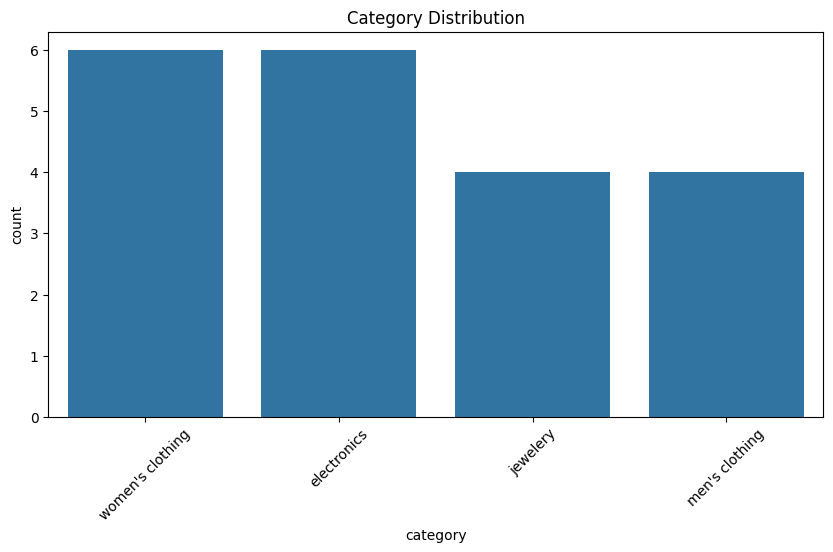

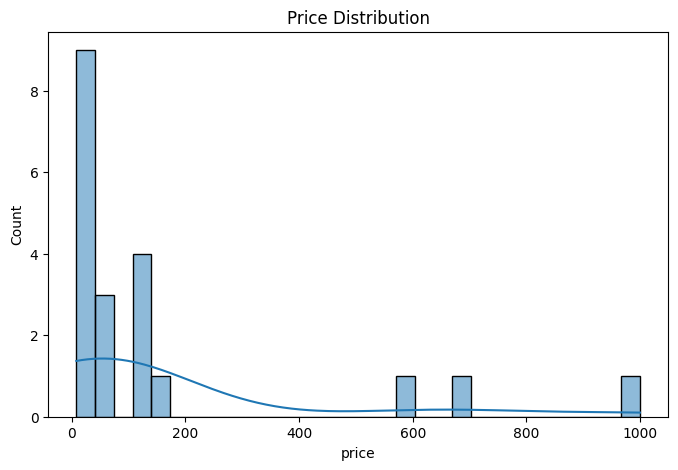

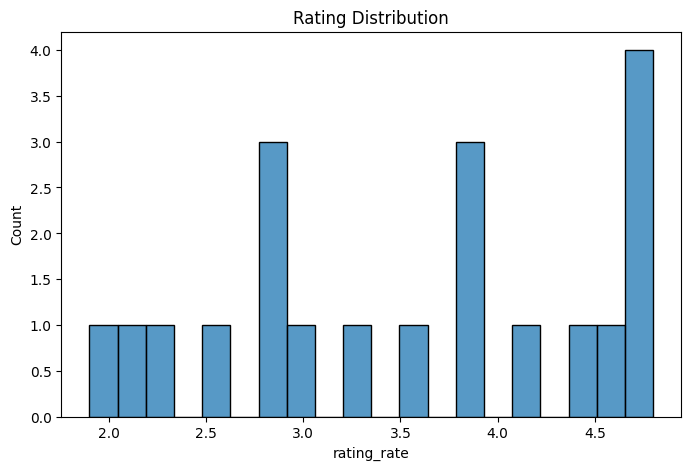

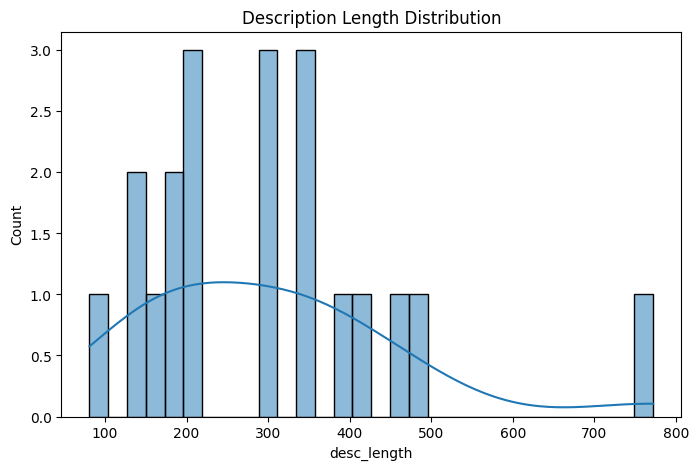


Top 10 longest descriptions:


,title,desc_length,description
14,BIYLACLESEN Women's 3-in-1 Snowboard Jacket Wi...,772,"Note:The Jackets is US standard size, Please c..."
9,SanDisk SSD PLUS 1TB Internal SSD - SATA III 6...,495,"Easy upgrade for faster boot up, shutdown, app..."
10,Silicon Power 256GB SSD 3D NAND A55 SLC Cache ...,457,3D NAND flash are applied to deliver high tran...
12,Acer SB220Q bi 21.5 inches Full HD (1920 x 108...,420,21. 5 inches Full HD (1920 x 1080) widescreen ...
16,Rain Jacket Women Windbreaker Striped Climbing...,398,Lightweight perfet for trip or casual wear---L...
18,Opna Women's Short Sleeve Moisture,347,"100% Polyester, Machine wash, 100% cationic po..."
1,Mens Casual Premium Slim Fit T-Shirts,338,"Slim-fitting style, contrast raglan long sleev..."
13,Samsung 49-Inch CHG90 144Hz Curved Gaming Moni...,336,49 INCH SUPER ULTRAWIDE 32:9 CURVED GAMING MON...
2,Mens Cotton Jacket,307,great outerwear jackets for Spring/Autumn/Wint...
15,Lock and Love Women's Removable Hooded Faux Le...,307,100% POLYURETHANE(shell) 100% POLYESTER(lining...


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Category distribution
if 'category' in products_df.columns:
    plt.figure(figsize=(10,5))
    sns.countplot(data=products_df, x='category', order=products_df['category'].value_counts().index)
    plt.xticks(rotation=45)
    plt.title("Category Distribution")
    plt.show()

# Price distribution
if 'price' in products_df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(products_df['price'].dropna(), bins=30, kde=True)
    plt.title("Price Distribution")
    plt.show()

# Rating distribution
if 'rating' in products_df.columns and not products_df['rating'].empty:
    # Extract the 'rate' from the rating dictionary
    products_df['rating_rate'] = products_df['rating'].apply(lambda x: x['rate'] if isinstance(x, dict) and 'rate' in x else None)
    plt.figure(figsize=(8,5))
    sns.histplot(products_df['rating_rate'].dropna(), bins=20, kde=False)
    plt.title("Rating Distribution")
    plt.show()

# Description length analysis
if 'description' in products_df.columns:
    products_df['desc_length'] = products_df['description'].astype(str).apply(len)
    plt.figure(figsize=(8,5))
    sns.histplot(products_df['desc_length'], bins=30, kde=True)
    plt.title("Description Length Distribution")
    plt.show()

    print("\nTop 10 longest descriptions:")
    display(products_df[['title','desc_length','description']].sort_values(by='desc_length', ascending=False).head(10))

In [ ]:
# --- 3. Neural Network Feature Extraction ---
# We will now use a neural network to convert the text 'soup' into dense embeddings.

# Step 3.1: Tokenization
# Convert the text into a sequence of integers.
print("\nTokenizing text data...")
tokenizer = Tokenizer(num_words=5000, oov_token="<unk>")
tokenizer.fit_on_texts(products_df['soup'])
sequences = tokenizer.texts_to_sequences(products_df['soup'])
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

# Step 3.2: Padding
# Ensure all sequences have the same length by padding them.
print("Padding sequences...")
max_length = 100 # We can choose an appropriate max length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
print("Shape of padded sequences:", padded_sequences.shape)

# Step 3.3: Build the Embedding Model
# We define a simple model to learn embeddings.
# This model is not trained in a traditional sense for this task;
# we use it to transform our text data into meaningful vectors.
vocab_size = len(word_index) + 1
embedding_dim = 16 # Dimensionality of the embedding vector

input_layer = Input(shape=(max_length,))
# The Embedding layer turns positive integers (indexes) into dense vectors of fixed size.
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)
# GlobalAveragePooling1D averages the embeddings for all words in a product's description
# to get a single vector representation for the entire product.
pooling_layer = GlobalAveragePooling1D()(embedding_layer)

# Create a model that will output the embeddings
embedding_model = Model(inputs=input_layer, outputs=pooling_layer)
embedding_model.summary()

# Step 3.4: Generate Product Embeddings
# Use the model to predict (generate) the embeddings for our padded sequences.
print("\nGenerating product embeddings using the neural network...")
product_embeddings = embedding_model.predict(padded_sequences)
print("Shape of product embeddings matrix:", product_embeddings.shape)


# --- 4. Model Training (Cosine Similarity on Embeddings) ---
# Compute the cosine similarity between all pairs of product embeddings.
print("\nCalculating cosine similarity matrix on embeddings...")
cosine_sim = cosine_similarity(product_embeddings, product_embeddings)
print("Shape of the cosine similarity matrix:", cosine_sim.shape)

# Create a mapping from product titles to their index in the DataFrame.
indices = pd.Series(products_df.index, index=products_df['title']).drop_duplicates()


Tokenizing text data...
Found 593 unique tokens.
Padding sequences...
Shape of padded sequences: (20, 100)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 16)        │         9,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,504 (37.12 KB)

 Trainable params: 9,504 (37.12 KB)

 Non-trainable params: 0 (0.00 B)


Generating product embeddings using the neural network...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Shape of product embeddings matrix: (20, 16)

Calculating cosine similarity matrix on embeddings...
Shape of the cosine similarity matrix: (20, 20)


In [ ]:
# --- 5. Recommendation Function ---
def get_recommendations(title, cosine_sim=cosine_sim, data=products_df):

    if title not in indices.index:
        return f"Product with title '{title}' not found."

    # Get the index of the product that matches the title.
    idx = indices[title]

    # Get the pairwise similarity scores of all products with that product.
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the products based on the similarity scores in descending order.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar products. Skip the first one.
    sim_scores = sim_scores[1:11]

    # Get the product indices from the similarity scores.
    product_indices = [i[0] for i in sim_scores]

    # Return the titles of the top 10 most similar products.
    return data['title'].iloc[product_indices]

In [ ]:
# --- 6. Example Usage ---
print("\n--- Recommendation Example ---")
if not products_df.empty:
    example_product_title = products_df['title'][0]
    print(f"Recommendations for: '{example_product_title}'\n")
    recommendations = get_recommendations(example_product_title)
    print(recommendations)

    print("\n" + "="*30 + "\n")
    example_product_title_2 = products_df['title'][5]
    print(f"Recommendations for: '{example_product_title_2}'\n")
    recommendations_2 = get_recommendations(example_product_title_2)
    print(recommendations_2)
else:
    print("Cannot generate recommendations because no product data is available.")

# This `else` block was causing the IndentationError
# else:
#     print("\nScript finished. Could not proceed with model training due to data fetching issues.")


--- Recommendation Example ---
Recommendations for: 'Fjallraven - Foldsack No. 1 Backpack, Fits 15 Laptops'

6                            White Gold Plated Princess
11    WD 4TB Gaming Drive Works with Playstation 4 P...
3                                  Mens Casual Slim Fit
7     Pierced Owl Rose Gold Plated Stainless Steel D...
4     John Hardy Women's Legends Naga Gold & Silver ...
2                                    Mens Cotton Jacket
19           DANVOUY Womens T Shirt Casual Cotton Short
1                Mens Casual Premium Slim Fit T-Shirts 
5                          Solid Gold Petite Micropave 
17          MBJ Women's Solid Short Sleeve Boat Neck V 
Name: title, dtype: object


Recommendations for: 'Solid Gold Petite Micropave '

7     Pierced Owl Rose Gold Plated Stainless Steel D...
6                            White Gold Plated Princess
11    WD 4TB Gaming Drive Works with Playstation 4 P...
2                                    Mens Cotton Jacket
4     John Hardy Women's